In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#function from lab 3
def imshow(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.
    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() 

def showMatches(img1, kp1, img2, kp2, matches, name):
    img = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imshow([img],[name])

In [3]:
video_path = "sample.mp4"

cap = cv2.VideoCapture(video_path)   #open our sample
original_codec = int(cap.get(cv2.CAP_PROP_FOURCC))    #the format of our sample
images = []     #images of our sample
if not cap.isOpened():
    print("Impossible d'ouvrir la vidéo.")
else:
    while True:
        ret, frame = cap.read()
            
        if not ret:
            break
        
        _, img_png = cv2.imencode(".png", frame)
        images.append(cv2.imdecode(np.frombuffer(img_png, np.uint8), cv2.IMREAD_COLOR))
    cap.release()

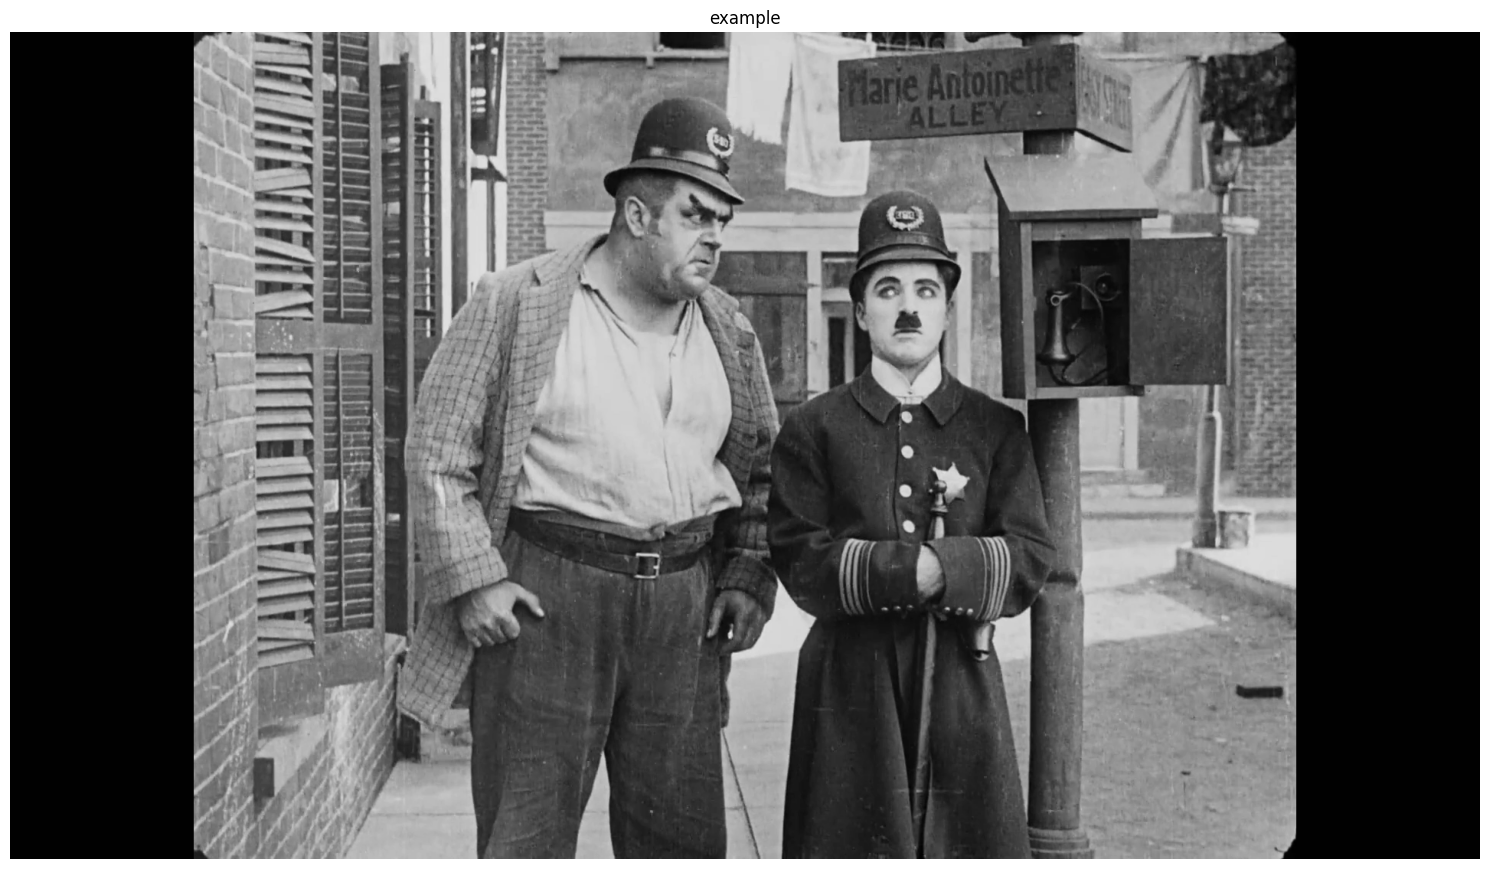

In [4]:
imshow([images[0]], ["example"])

In [5]:
#adaptation of function from lab 3

def extract_key_points(images):   #extract key points from all frames
    akaze = cv2.AKAZE_create()
    key_points = []
    for image in images:
        key_points.append(akaze.detectAndCompute(image, None))
    return key_points

def match_key_points(key_points):    #match key points from all frames with key points from frame 0
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    tab_matches = []
    for i in range(len(key_points) - 1):
        kp1,des1 = key_points[0]
        kp2,des2 = key_points[i+1]
        matches = bf.match(des1,des2)
        tab_matches.append(sorted(matches, key = lambda x:x.distance))
    return tab_matches

def findHomography(tab_matches, key_points):   #estimate homography between all frames and frame and frame 0
    tab_H = []
    for i in range(len(tab_matches)):
        keypoint1, _ = key_points[0]
        keypoint2, _ = key_points[i+1]
        matches = tab_matches[i]
        src_pts = np.array([keypoint1[match.queryIdx].pt for match in matches])
        dst_pts = np.array([keypoint2[match.trainIdx].pt for match in matches])
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
        tab_H.append(H)
    return tab_H

def transformation(images, tab_H, size):    #aligne all frames with the frame 0
    I = np.identity(3)
    images_transformed = [cv2.warpPerspective(images[0], I, size)]
    
    for i in range(len(tab_H)):
        img = np.ones_like(images[0]) * 255
        H_affine = tab_H[i]
        img = cv2.warpPerspective(images[i+1], H_affine, size, img, flags=cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
        images_transformed.append(img)
    return images_transformed

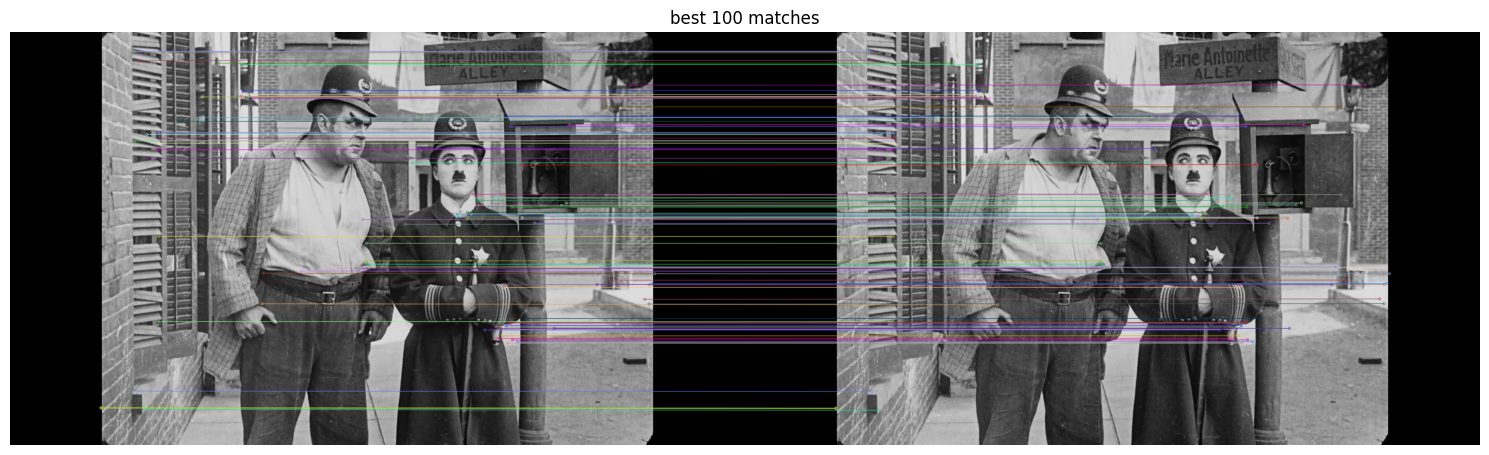

In [6]:
key_points = extract_key_points(images)
tab_matches = match_key_points(key_points)

kp1,des1 = key_points[0]
kp2,des2 = key_points[1]
showMatches(images[0],kp1,images[1],kp2,tab_matches[0][:100],"best 100 matches")

In [7]:
tab_H = findHomography(tab_matches, key_points)

size = (images[0].shape[1], images[0].shape[0])
images_stabilization = transformation(images, tab_H, size)    #obtain the images stabilized

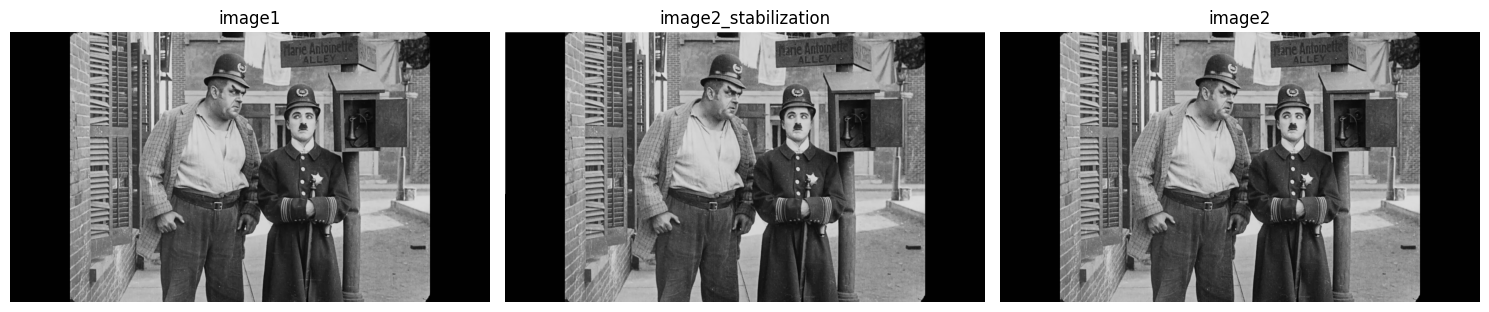

In [8]:
imshow([images_stabilization[0], images_stabilization[1], images[1]],["image1", "image2_stabilization", "image2"])
#the difference is not visible directly

In [9]:
def create_video(images, output_path, fps=25):   #creation of the video from the images
    height, width, _ = images[0].shape
    fourcc = original_codec    #to have the same format than the sample
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for img in images:
        out.write(img)
    out.release()

In [10]:
#this code removes the white band that appear on the side because of the transformation
"""print(images_stabilization[0].shape)   

for i in range(len(images_stabilization)):
    images_stabilization[i] = images_stabilization[i][10: -10, 10: -10]

print(images_stabilization[0].shape)"""

(1080, 1920, 3)
(1060, 1900, 3)


In [11]:
output_video_path = "video_stabilization.mp4"
create_video(images_stabilization, output_video_path)

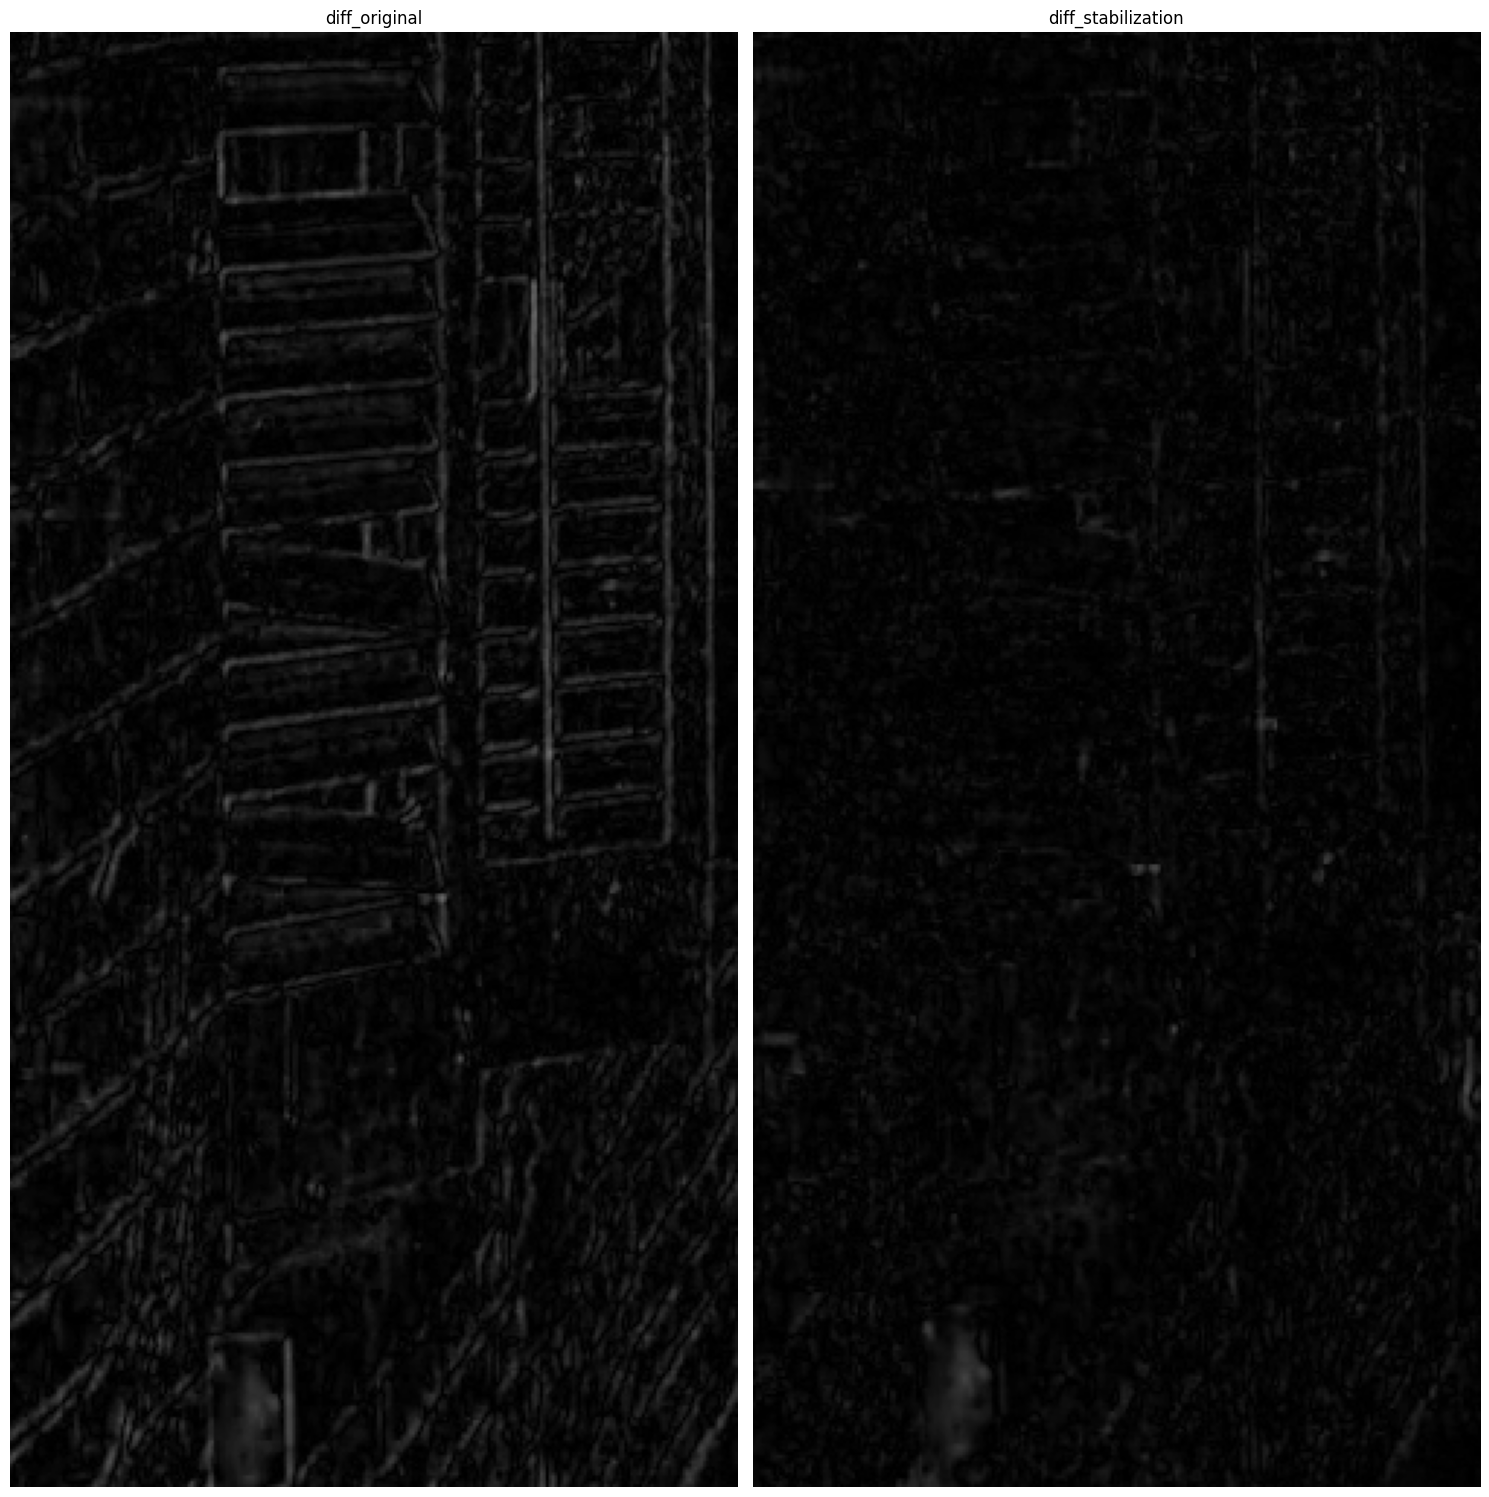

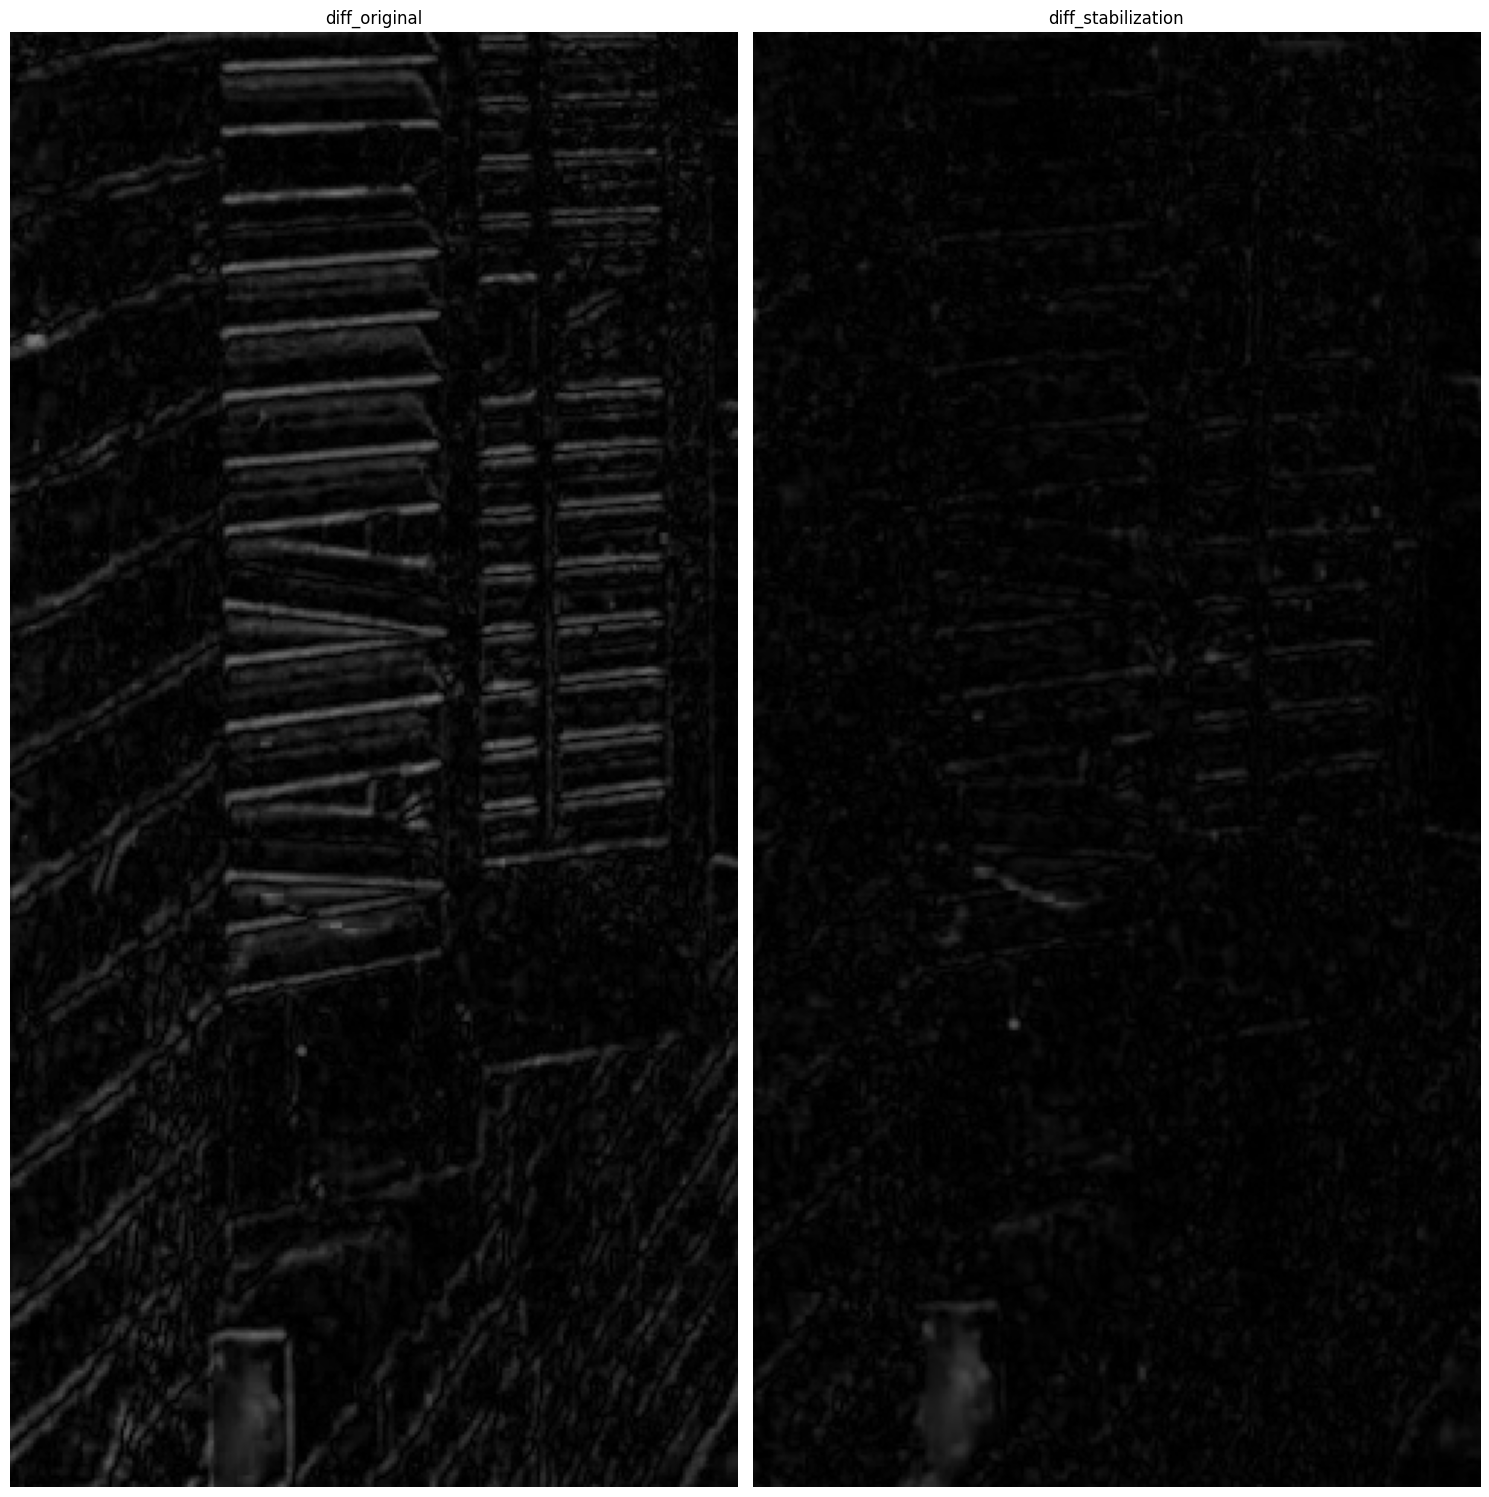

In [12]:
#in order to see the improvement we print the differences between the first and tenth frame
prev_frame = 0
next_frame = 10
for i in range(2):
    frame_diff = cv2.absdiff(images[prev_frame][500:1000, 250:500], images[next_frame][500:1000, 250:500])   #we select the shutters in the images
    frame_diff_stabilization = cv2.absdiff(images_stabilization[prev_frame][500:1000, 250:500], images_stabilization[next_frame][500:1000, 250:500])
    imshow([frame_diff, frame_diff_stabilization],["diff_original", "diff_stabilization"])
    prev_frame += 10
    next_frame += 10